# **SETUP/IMPORTS** 

In [ ]:
import numpy as np
import pandas as pd
import string

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
colors = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(colors))
matplotlib.rcParams['figure.figsize'] = 12, 8

# **IMPORT DATASET**

In [ ]:
train = pd.read_csv('training.csv')
test = pd.read_csv('test.csv')
validation = pd.read_csv('validation.csv')

In [ ]:
labels_dict = {0:'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}
train['description'] = train['label'].map(labels_dict )
train.head()

,text,label,description
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [ ]:
train['description'].value_counts(normalize=True)

joy         0.335125
sadness     0.291625
anger       0.134937
fear        0.121063
love        0.081500
surprise    0.035750
Name: description, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


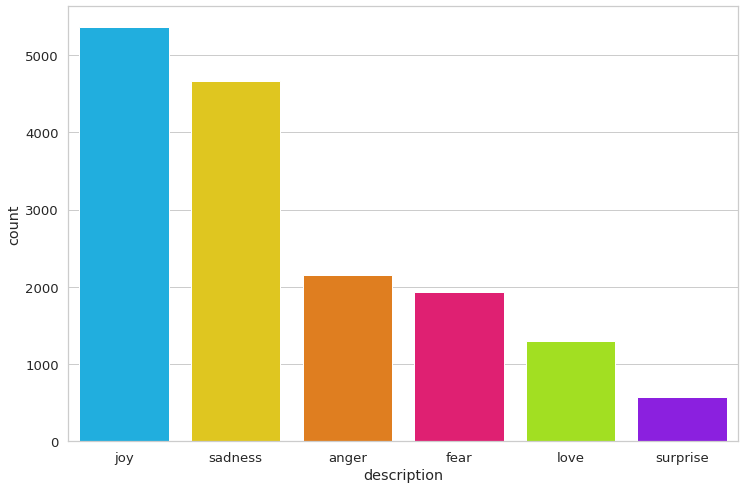

In [ ]:
sns.countplot(train['description'],order = train['description'].value_counts(normalize=True).index)

In [ ]:
train['text_length'] = train['text'].astype(str).apply(len)
train['text_word_count'] = train['text'].apply(lambda x: len(str(x).split()))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


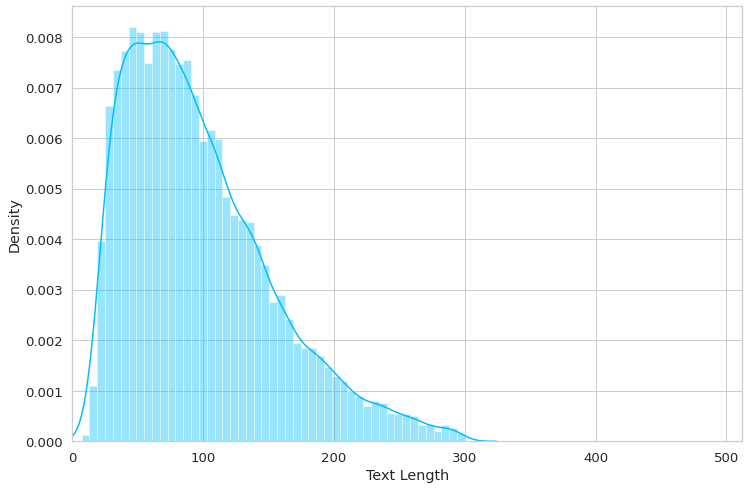

In [ ]:
sns.distplot(train['text_length'])
plt.xlim([0, 512]);
plt.xlabel('Text Length');

Preprocessing


In [ ]:
import unicodedata
import re
from nltk.corpus import stopwords
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def clean_stopwords_shortwords(w):
    stopwords_list=stopwords.words('english')
    words = w.split() 
    clean_words = [word for word in words if (word not in stopwords_list) and len(word) > 2]
    return " ".join(clean_words) 

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r"([?.!,¿])", r" ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w=clean_stopwords_shortwords(w)
    w=re.sub(r'@\w+', '',w)
    return w

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
print('Available labels: ',train.description.unique())
train['text']=train['text'].map(preprocess_sentence)

num_classes=len(train.description.unique())

train.head()

Available labels:  ['sadness' 'anger' 'love' 'surprise' 'fear' 'joy']


,text,label,description,text_length,text_word_count
0,didnt feel humiliated,0,sadness,23,4
1,feeling hopeless damned hopeful around someone...,0,sadness,108,21
2,grabbing minute post feel greedy wrong,3,anger,48,10
3,ever feeling nostalgic fireplace know still pr...,2,love,92,18
4,feeling grouchy,3,anger,20,4


In [ ]:
train=train.drop(['description','text_length','text_word_count'],axis=1)
train=train.reset_index(drop=True)
train.head()

,text,label
0,didnt feel humiliated,0
1,feeling hopeless damned hopeful around someone...,0
2,grabbing minute post feel greedy wrong,3
3,ever feeling nostalgic fireplace know still pr...,2
4,feeling grouchy,3


In [ ]:
def get_tweet(data):
  tweets = data['text']
  labels = data['label']
  return tweets, labels

In [ ]:
tweets, labels = get_tweet(train)

In [ ]:
tweets[0], labels[0]

('didnt feel humiliated', 0)

TOKENIZER


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [ ]:
tokenizer.texts_to_sequences([tweets[0]])

[[48, 2, 558]]

In [ ]:
tweets[0]

'didnt feel humiliated'

Padding and Truncating Sequences

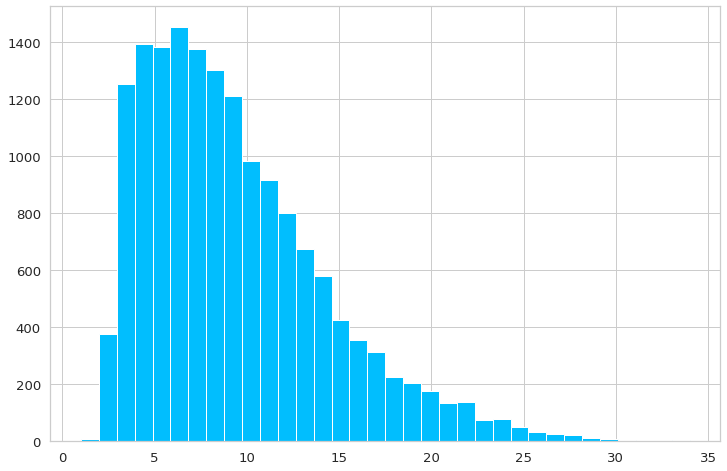

In [ ]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins = len(set(lengths)))
plt.show()


unique lengths in our dataset
mostly 5-10 length

In [ ]:
maxlen = 32

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
  return padded

In [ ]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [ ]:
padded_train_seq[0]

array([ 48,   2, 558,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0], dtype=int32)

Creating Model

In [ ]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 32, 16)            160000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 32, 40)           5920      
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


In [ ]:
val_tweets, val_labels = get_tweet(validation)
val_seq = get_sequences(tokenizer, val_tweets)

In [ ]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 0)

In [ ]:
h = model.fit(
    padded_train_seq, labels,
    validation_data=(val_seq, val_labels),
    epochs=20,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 25s 39ms/step - loss: 1.1365 - accuracy: 0.5630 - val_loss: 1.0121 - val_accuracy: 0.6300
Epoch 2/20
500/500 [==============================] - 17s 35ms/step - loss: 0.4122 - accuracy: 0.8604 - val_loss: 0.7388 - val_accuracy: 0.7250
Epoch 3/20
500/500 [==============================] - 17s 35ms/step - loss: 0.2713 - accuracy: 0.9095 - val_loss: 0.7783 - val_accuracy: 0.7330
Epoch 4/20
500/500 [==============================] - 17s 35ms/step - loss: 0.2092 - accuracy: 0.9306 - val_loss: 0.6597 - val_accuracy: 0.7825
Epoch 5/20
500/500 [==============================] - 18s 35ms/step - loss: 0.1644 - accuracy: 0.9486 - val_loss: 0.7029 - val_accuracy: 0.7800
Epoch 6/20
500/500 [==============================] - 18s 35ms/step - loss: 0.1357 - accuracy: 0.9595 - val_loss: 0.5885 - val_accuracy: 0.8155
Epoch 7/20
500/500 [==============================] - 17s 34ms/step - loss: 0.1084 - accuracy: 0.9664 - val_loss: 1.1399 - val_accuracy:

Evaluating the Model

In [ ]:
import random

def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

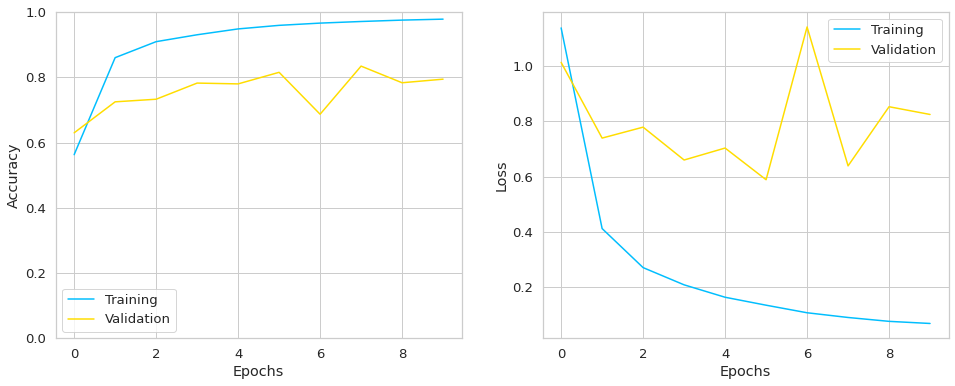

In [ ]:
show_history(h)

In [ ]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)

In [ ]:
_=model.evaluate(test_seq, test_labels)

63/63 [==============================] - 1s 11ms/step - loss: 0.8554 - accuracy: 0.7860


In [ ]:
i = random.randint(0, len(test_labels) -1)
print("Tweet: ", test_tweets[i])
print("Emotion: ", test_labels[i])

p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = np.argmax(p).astype('uint8')

print('Predicted Emotion: ', pred_class)

Tweet:  i feel so useless some days
Emotion:  0
Predicted Emotion:  0
